# Hierarchical Model

This notebook shows how to calculate the predictive distirbution. There are two kind of predictive distribution of hierarchical model. Suppose that you track the number of pages you read by day. Y represents the number of pages(page/day). 

**Model**
\begin{align}
Y_i|\lambda_i &\sim \mathrm{Po}(\lambda_i) \\
\lambda_i|\beta &\sim \mathrm{Gamma}(\alpha, \beta) \\
\beta &\sim \mathrm{Exp}(\mu_\beta)
\end{align}

**hyper parameters**
\begin{equation}
\alpha = 6,\quad \mu_{\beta} = 10^{-4}
\end{equation}

## 0. Import

In [1]:
using Plots
using Distributions
using SpecialFunctions
pyplot()

Plots.PyPlotBackend()

## 1. posterior samples

In [2]:
function my_Gibbs_sampler(Y, n_samps, n_burnin, α, μ_β)
    N = length(Y)    
    λsamps = zeros(N, n_samps)
    βsamps = zeros(n_samps)
    λsamps[:,1] = ones(N)
    βsamps[1] = 1.
    for s in 2:n_samps
        for i in 1:N
            λsamps[i,s] = rand(Gamma(Y[i]+α, 1/(βsamps[s-1]+1)))
        end
        βsamps[s] = rand(Gamma(α*N+1, 1/(μ_β+sum(λsamps[:,s]))))
    end
    return λsamps[:,n_burnin:end], βsamps[n_burnin:end]
end

#create the data
Y = [11, 10, 9, 8, 14, 13, 12, 13, 11]
N = length(Y)

#set the paramters and sample from posterior
α = 11.0
μβ = 1e-4
n_samps = 10000
n_burnin = div(n_samps, 10)
λsamps, βsamps = my_Gibbs_sampler(Y, n_samps, n_burnin, α, μβ)

([12.23587800128784 13.11638041572092 … 8.892227493725963 10.893067049037045; 8.780211906771669 12.592110631212126 … 14.610163048075904 9.136293590686899; … ; 9.64961797404995 11.645981163896227 … 11.582263983200033 8.714682647147729; 11.906570521555981 14.243968350350128 … 10.665896903111442 14.236662001495416], [0.8824382302575093, 0.8909268638961666, 0.90686457957973, 0.9408067245753017, 0.9564332852544484, 1.1124437109856633, 1.0680467006589132, 1.1015937356282848, 1.072927329595118, 0.9213758456980221  …  0.9419118022474181, 1.0561893041981576, 1.2505877744302092, 0.9261436744723492, 0.8794789457511641, 1.085340378403239, 0.8477792958958899, 1.0741066067442937, 1.1047062808775723, 0.902449987433261])

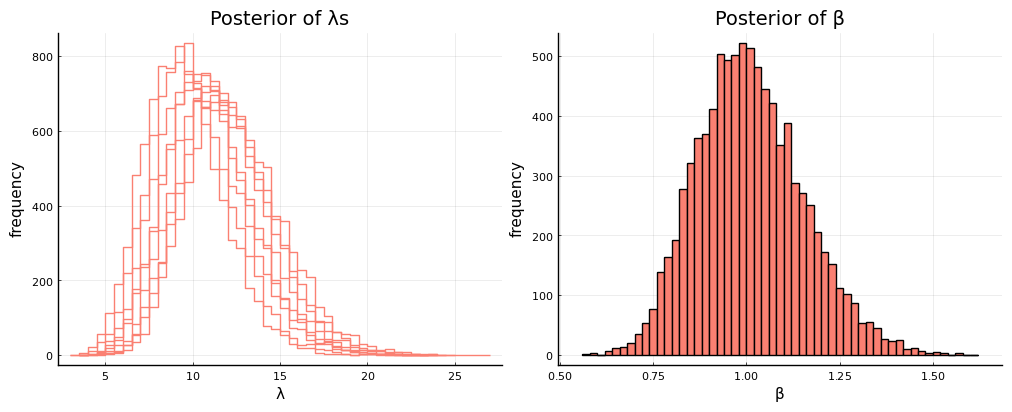

In [3]:
#plot the posterior
λ_hist = plot(title="Posterior of λs", xlabel="λ", ylabel="frequency", color=:salmon, legend=false)
for n in 1:N
   plot!(λsamps[n,:], color=:salmon, st=:stephist, label=false) 
end
β_hist = plot(βsamps, title="Posterior of β", xlabel="β", ylabel="frequency", st=:histogram, color=:salmon, legend=false)
fig1 = plot(λ_hist, β_hist, size=(1000, 400))
#savefig(fig1, "figs-HM/fig1.png")

## 2. prediction

### prediction1: How many pages you will read if you read the book you've already read.

#### method 1

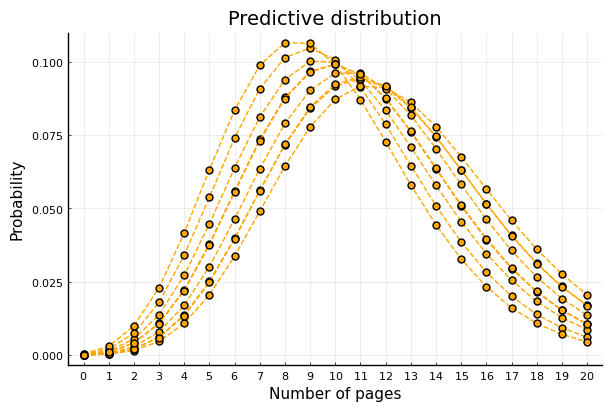

In [4]:
#model pf
lik(y, λ) = pdf(Poisson(λ), y)

#predictive pf
function pred1(y, λsamps)
    S = length(λsamps)
    preds = zeros(S)
    for s in 1:S
        preds[s] = lik(y, λsamps[s])
    end
    return mean(preds)
end

#calculate the probability
Ys = 0:1:20
preds1 = zeros(N, length(Ys))
for n in 1:N
    for i in 1:length(Ys)
        preds1[n,i] = pred1(Ys[i], λsamps[n,:])
    end
end

#show the result
fig2 = plot(xlabel="Number of pages", ylabel="Probability", title="Predictive distribution", xticks=Ys, legend=false)
for n in 1:N
    plot!(Ys, preds1[n,:], color=:orange, markershape=:circle, markersize=5, ls=:dash)
end
#savefig(fig2, "figs-HM/fig2.png")

#### method 2

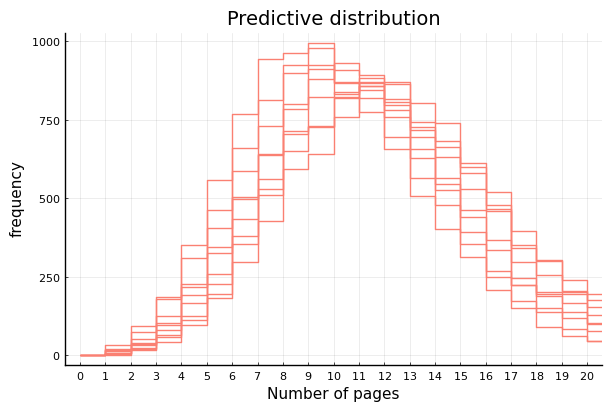

mean of ith predictive distribution = 10.942117542495279. 
mean of ith predictive distribution = 10.496611487612487. 
mean of ith predictive distribution = 9.957893567381403. 
mean of ith predictive distribution = 9.511387623597377. 
mean of ith predictive distribution = 12.507721364292856. 
mean of ith predictive distribution = 12.04732807465837. 
mean of ith predictive distribution = 11.51260971003222. 
mean of ith predictive distribution = 11.950561048772359. 
mean of ith predictive distribution = 10.978224641706477. 


In [5]:
#predictive samples
function pred2(λsamps)
    S = length(λsamps)
    Ysamps = zeros(S)
    for s in 1:S
        Ysamps[s] = rand(Poisson(λsamps[s]))
    end
    return Ysamps
end

#sample from predictive distribution
preds2 = zeros(N,length(βsamps))
for n in 1:N
    preds2[n,:] = pred2(λsamps[n,:])
    println("mean of ith predictive distribution = $(mean(preds2[n,:])). ")
end

#show the result
fig3 = plot(title="Predictive distribution", xlabel="Number of pages", ylabel="frequency", color=:salmon, legend=false, xticks=range(0,20,step=1), xlim=[0,20])
for n in 1:N
   plot!(preds2[n,:], color=:salmon, st=:stephist, label=false, bins=50) 
end
#savefig(fig3, "figs-HM/fig3.png")

### prediction2: How many pages you will read if you read a new book?

#### method 1

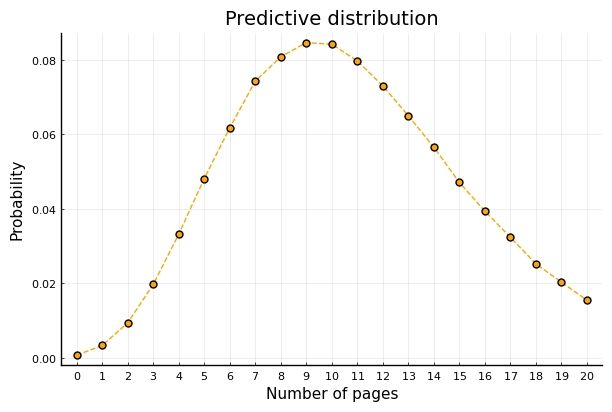

In [6]:
#model pf
lik(y, λ) = pdf(Poisson(λ), y)

#predictive pf
function pred3(y, α, βsamps)
    S = length(βsamps)
    preds = zeros(S)
    for s in 1:S
        λ = rand(Gamma(α, 1/βsamps[s]))
        preds[s] = lik(y, λ)
    end
    return mean(preds)
end

#calculate the probability
Ys = 0:1:20
preds3 = zeros(length(Ys))
for i in 1:length(Ys)
    preds3[i] = pred3(Ys[i], α, βsamps)
end

#show the result
fig4 = plot(xlabel="Number of pages", ylabel="Probability", title="Predictive distribution", xticks=Ys, legend=false)
plot!(Ys, preds3, color=:orange, markershape=:circle, markersize=5, ls=:dash)
#savefig(fig4, "figs-HM/pred4.png")

#### method 2

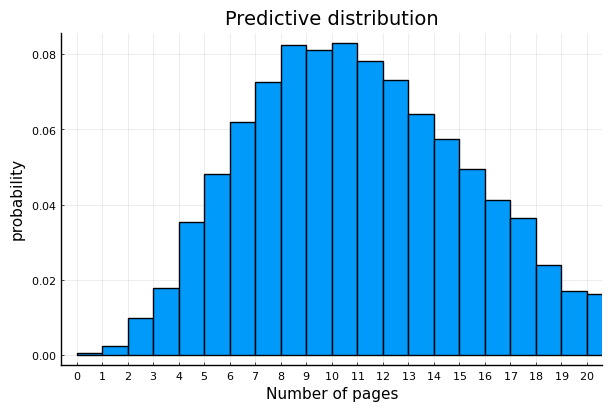

mean of the predictive distribution = 11.148


In [7]:
#predictive pf
function pred4(α, βsamps)
    S = length(βsamps)
    Ysamps = zeros(S)
    for s in 1:S
        λ = rand(Gamma(α, 1/βsamps[s]))
        Ysamps[s] = rand(Poisson(λ))
    end
    return Ysamps
end

#sample from predictive distribution
preds4 = pred4(α, βsamps)
println("mean of the predictive distribution = $(round(mean(preds4), digits=3))")

#show the result
fig5 = plot(preds4, title="Predictive distribution", xlabel="Number of pages", ylabel="probability", st=:histogram, legend=false, normed=true, xticks=range(0,20,step=1), xlim=[0,20])
#savefig(fig5, "figs-HM/fig5.png")

#### method 3

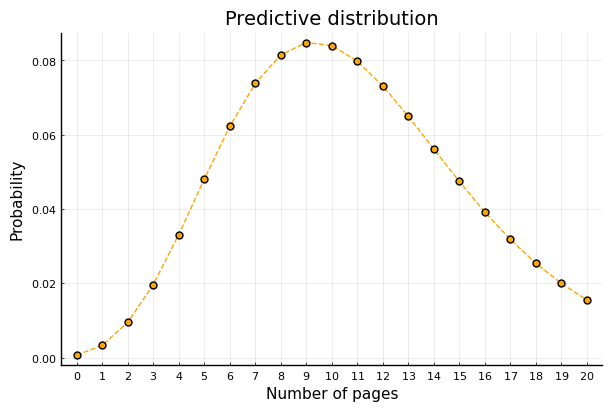

In [8]:
lik2(y, α, β) = β^α*gamma(y+α)/gamma(α)/factorial(y)/(β+1)^(y+α)

#predictive pf
function pred5(y, α, βsamps)
    S = length(βsamps)
    preds = zeros(S)
    for s in 1:S
       preds[s] = lik2(y, α, βsamps[s]) 
    end
    return mean(preds)
end

#calculate the probability
Ys = 0:1:20
preds5 = zeros(length(Ys))
for i in 1:length(Ys)
    preds5[i] = pred5(Ys[i], α, βsamps)
end

#show the result
fig6 = plot(xlabel="Number of pages", ylabel="Probability", title="Predictive distribution", xticks=Ys, legend=false)
plot!(Ys, preds5, color=:orange, markershape=:circle, markersize=5, ls=:dash)
#savefig(fig6, "figs-HM/fig6.png")